# Reduction

This notebook will demonstrate basic OPTICAM data reduction using `opticam`.

## Performance Tip

Before starting, it's worth noting that `opticam` uses the `multiprocessing` Python module to parallelize data reduction across multiple CPU cores. For the best scaling, it's therefore a good idea to disable automatic parallelization by any underlying libraries (like `numpy`) using some combination of the following:

In [1]:
import os

# limit underlying math libraries to a single thread for better multiprocessing performance
os.environ['OMP_NUM_THREADS'] = '1'  # OpenMP
# os.environ['OPENBLAS_NUM_THREADS'] = '1'  # OpenBLAS
# os.environ['MKL_NUM_THREADS'] = '1'  # Intel Math Kernel Library
# os.environ['VECLIB_MAXIMUM_THREADS'] = '1'  # Apple Accelerate vector library

The relevant libraries will depend on the specific system you're using; in my case, I only need to include `os.environ['OMP_NUM_THREADS'] = '1'`.

**Warning**: if you do not disable automatic parallelization as shown above, cosmic ray removal will *hang*. It is therefore necessary to either disable automatic parallelization as shown above or disable cosmic ray removal by passing `remove_cosmic_rays=False` to `opticam.Reducer`.

## Generating Data

Before we can beging reducing data, we need some data to reduce. `opticam` provides a routine for generating some dummy observations via the `generate_observations()` function:

In [2]:
import opticam

opticam.generate_observations(
    out_dir='reduction_tutorial/data',  # path to the directory where the generated data will be saved
    circular_aperture=False,  # disable circular aperture shadow
    n_images=20,
    )

[OPTICAM] variable source is at (122, 104)


Generating observations: 100%|██████████|[00:06<00:00]


These dummy observations come in three filters: $g$, $r$, and $i$, and will be used in many of the guided tutorials. We can also see that there is a variable source at (122, 104), which we will use as our source of interest.

There are a number of parameters that can be tweaked when calling `generate_observations()`, such as the number of images, the binning scale of the images, and whether a circular aperture shadow is applied to the images. For this example, I've only generated a small number of images to minimise storage and ensure this notebook runs quickly.

## Defining a `Reducer`

Now that we have some data, we can begin reducing it. Before we do, however, it's often a good idea to run `opticam.check_data()`, especially if you're unfamiliar with the data. This scans the image headers and to ensure that:
1. There are no more than three unique filters used to capture the images in the specified directory/directories. If more than three unique filters are found, an error will be raised with information on how to resolve the issue.
2. All the images in the specified directory use the same binning. If multiple binning values are detected, an error will be raised with information on how to resolve the issue.

It will also output some useful information that could guide how you reduce the data, such as the binning mode, filters, and how many images were found. Let's take a look:

In [3]:
opticam.check_data(
    out_directory='reduction_tutorial/reduced',
    data_directory='reduction_tutorial/data',
)

[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]

[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 20 g-band images.
[OPTICAM] 20 r-band images.
[OPTICAM] 20 i-band images.


As we can see, the images use the 4x4 binning mode, we have $g$-, $r$-, and $i$-band images, and there are 20 images for each filter. Since there were no issues with the data, we can instance proceed with reduction by defining a `Reducer` instance.

There are multiple ways to define a `Reducer` instance, depending on how the images are stored on your system. If all the images are saved in a single directory (for example, if the observations were made using 1 PC mode), you can pass the path to this directory to the `data_directory` parameter. These images will then be separated by camera automatically. If, however, you already have images from separate cameras stored in separate directories (for example, if the observations were made using 3 PC mode), you may pass the path to the directory containing the images from camera 1 to `c1_directory`, and so on for cameras 2 and 3. The same is also true for `opticam.check_data()`. 

In addition to defining the data directory/directories, `data_directory` (or `c1_directory`, etc.), it is also necessary to define an output directory, `out_directory`. This is the directory in which all the output files will be saved. If the specified directory does not exist, `opticam` will attempt to create it. We can also apply flat-field corrections to our images by passing a `FlatFieldCorrector`, though we will not do this here (see the [corrections tutorial](applying_corrections.ipynb) for details on applying flat-field corrections):

[OPTICAM] reduction_tutorial/reduced not found, attempting to create ...
[OPTICAM] reduction_tutorial/reduced created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 20 g-band images.
[OPTICAM] 20 r-band images.
[OPTICAM] 20 i-band images.


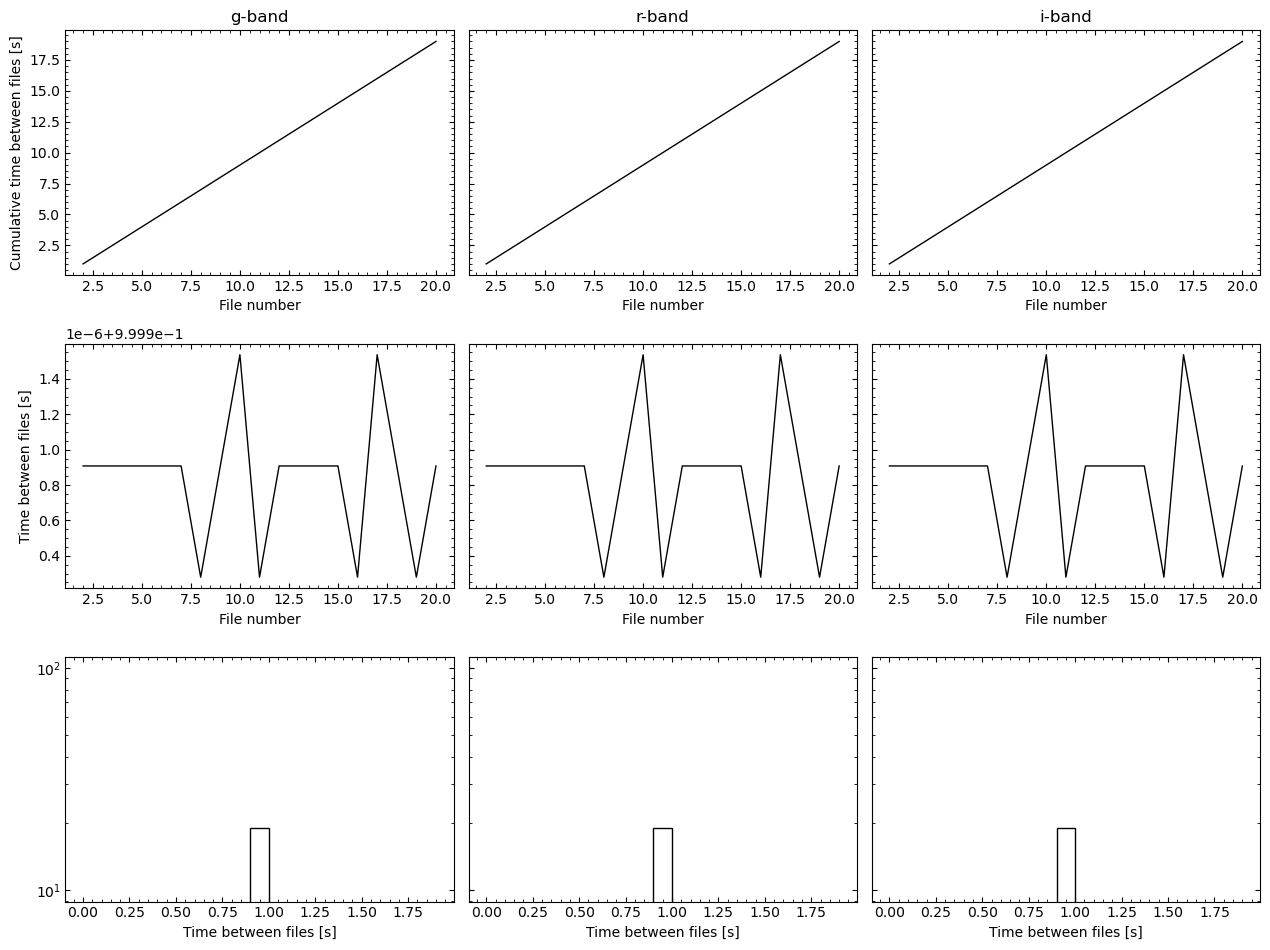

In [4]:
reducer = opticam.Reducer(
    data_directory='reduction_tutorial/data',  # path to the data
    out_directory='reduction_tutorial/reduced',  # path to where the output will be saved
    remove_cosmic_rays=False,  # our simulated data do not contain cosmic rays
    show_plots=True,  # show plots (useful for diagnosis and debugging)
    verbose=True,  # print out information about the catalog creation (useful for diagnosis and debugging)
    )

After creating a `Reducer` instance, `opticam.check_data()` is ran to ensure there are no issues with the data; as mentioned above, this may result in errors that will need to be resolved. In this case, however, we can see that there are no errors, and so we can proceed with reduction.

## Create Source Catalogs

The next step is to create source catalogs for each camera. Creating source catalogs requires aligning each camera's images to track sources over time and ensure consistent labelling. The way in which images are aligned can be customised. By default, images will be aligned using `transform_type='affine'` which uses the `astroalign` package. Alternatively, passing `transform_type='translation'` will compute simple (x, y) translations between images. The number of reference sources can also be changed by passing the desired value to `n_alignment_sources`. When using `transform_type='translation'`, `n_alignment_sources` must be $\geq 1$ while `transform_type='affine'` requires `n_alignment_sources` be $\geq 3$.

To create the source catalogs, we must call the `create_catalogs()` method:

[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]

[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.



[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


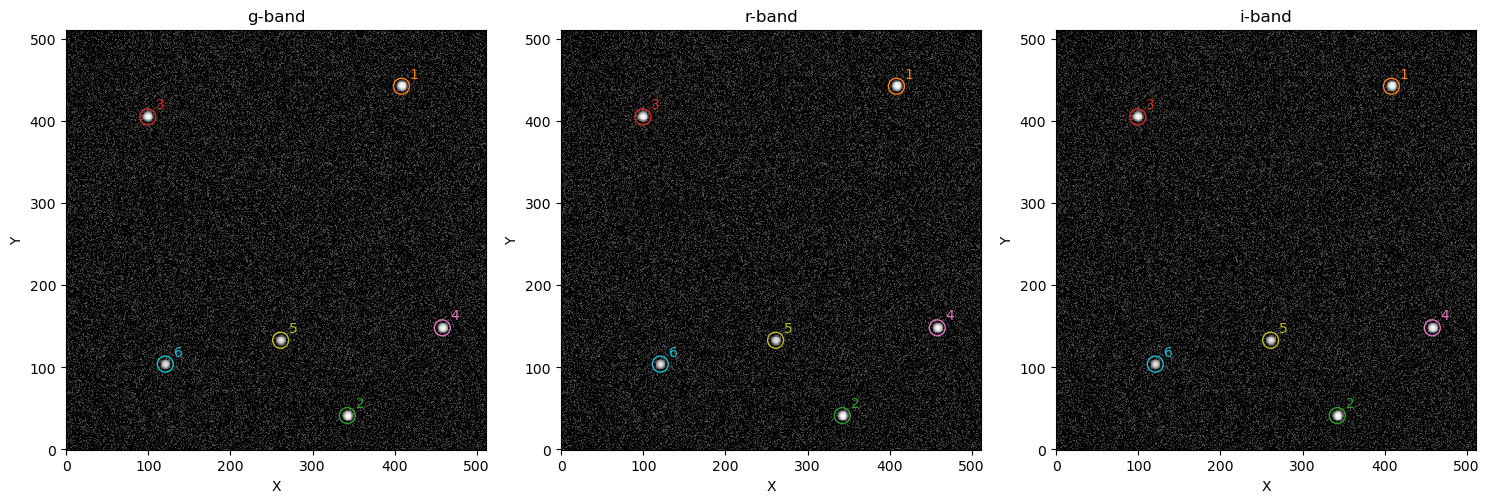

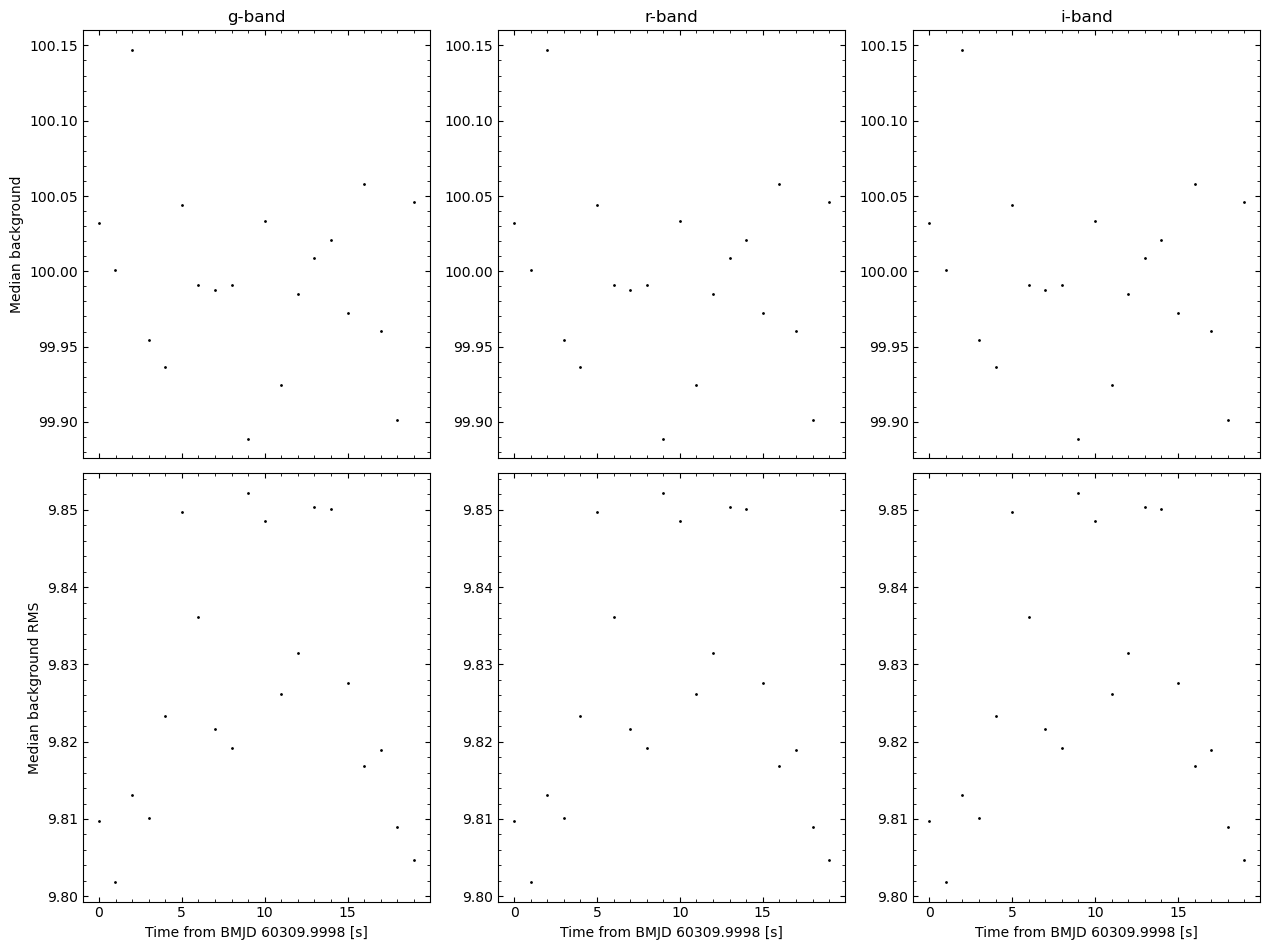

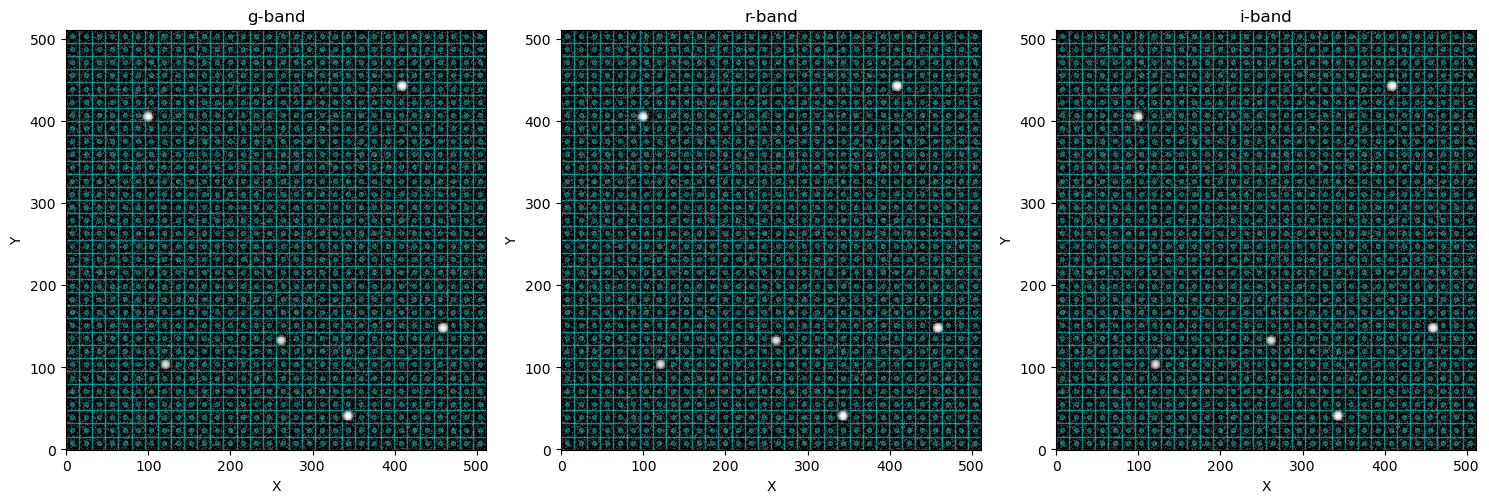

In [5]:
reducer.create_catalogs(
    show_diagnostic_plots=True,
    )

We can see that six sources have been identified in each of the three sets of images. In this example, the source labelling is consistent across the catalogs because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter (more on this later). After initialising our catalogs, a number of diagnostic plots are also generated. By default, these plots are not shown but are saved to the `out_directory/diag` directory. In this case, we passed `show_diagnosis_plots=True` and so we can see these plots:
1. The first diagnosis plot shows the average background as a function of time for each camera. This can be useful to check for structure in the average background.
2. The second diagnosis plot shows the 2D background mesh. This is useful to check how large the sources are relative to the 2D background "pixels". The background "pixels" should be larger than the typical source size, but small enough to capture background variations across the image. By default, `opticam` will define these background "pixels" to be 1/16th of the size of the image in both dimensions, which is usually a pretty good size.

The background parameters are discussed in more detail in the [background tutorial](backgrounds.ipynb).

## Performing Photometry

With our catalogs defined, we can now perform photometry. Performing photometry in `opticam` requires a photometer object that inherits from `opticam.photometers.BasePhotometer`. Currently, `opticam` provides two photometers: `AperturePhotometer`, for performing simple aperture photometry, and `OptimalPhotometer`, for performing optimal photometry (as described in [Naylor 1998, MNRAS, 296, 339-346](https://ui.adsabs.harvard.edu/abs/1998MNRAS.296..339N/abstract)). Both photometers can be customised to perform "forced photometry", and can use either the `Reducer`'s 2D background estimator or estimate the local background around each source using an annulus. In this example, I'll show a couple of different photometry configurations:

In [6]:
# aperture photometer with local background estimations
default_annulus_photometer = opticam.AperturePhotometer(
    forced=False,
    source_matching_tolerance=2.,
    local_background_estimator=opticam.DefaultLocalBackground(),  # use the default local background estimator
)

# optimal photometer
# implements the method described in Naylor 1998, MNRAS, 296, 339-346
optimal_photometer = opticam.OptimalPhotometer(
    forced=False,
    source_matching_tolerance=2.,
    local_background_estimator=None,
)

Once a photometer has been defined, it can be passed to the `photometry()` method of `Catalog` to compute the raw light curves:

In [7]:
reducer.photometry(default_annulus_photometer)  # using the aperture photometer with local background estimations

[OPTICAM] Photometry results will be saved to aperture_annulus_light_curves in reduction_tutorial/reduced.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]


When you perform photometry on a catalog, the directory to which the light curves are saved will depend on how the photometer is configured:
1. If the photometer is defined with `forced=True`, the directory will have a "forced" prefix.
2. If a local background estimator is passed to the photometer's `local_background_estimator` parameter, then the directory will also have an "annulus" suffix.

In the above case, we used the `AperturePhotometer` with a local background estimator and so we can see that the raw light curves have been saved to a "aperture_annulus_light_curves" directory. Let's compare this to the subdirectory for light curves produced by our `optimal_photometer`:

In [8]:
reducer.photometry(optimal_photometer)  # using the optimal photometer

[OPTICAM] Photometry results will be saved to optimal_light_curves in reduction_tutorial/reduced.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:01<00:00]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]


In this case there is no prefix nor suffix, and only the name of the photometer class is included.

## Computing Relative Light Curves

We now have some raw light curves using a couple of different photometry configurations. However, raw light curves contain a lot of atmospheric and systematic variability, and so we often want to compute the relative light curve between our source of interest and some comparison sources to reduce this atmospheric/systematic variability.

In this example, let's say that Source 6 is our target of interest (since we know that it's varying), and use Source 5 for comparison. In this example, the choice of comparison source(s) is arbitraray (since there are no atmospheric/systematic variations in our simulated data). In practise, however, choosing suitable comparison sources is vital for obtaining quality light curves, though a discussion of this is beyond the scope of this tutorial.

Let's now produce a relative light curve for Source 6 using the "aperture_annulus" light curves created by `default_annulus_photometer`. First, however, we need to initialise a `DifferentialPhotometer` object. When initialising a `DifferentialPhotometer` object, we need to pass the directory path to the reduced data created by `Reducer`:

[OPTICAM] Filters: g-band, r-band, i-band


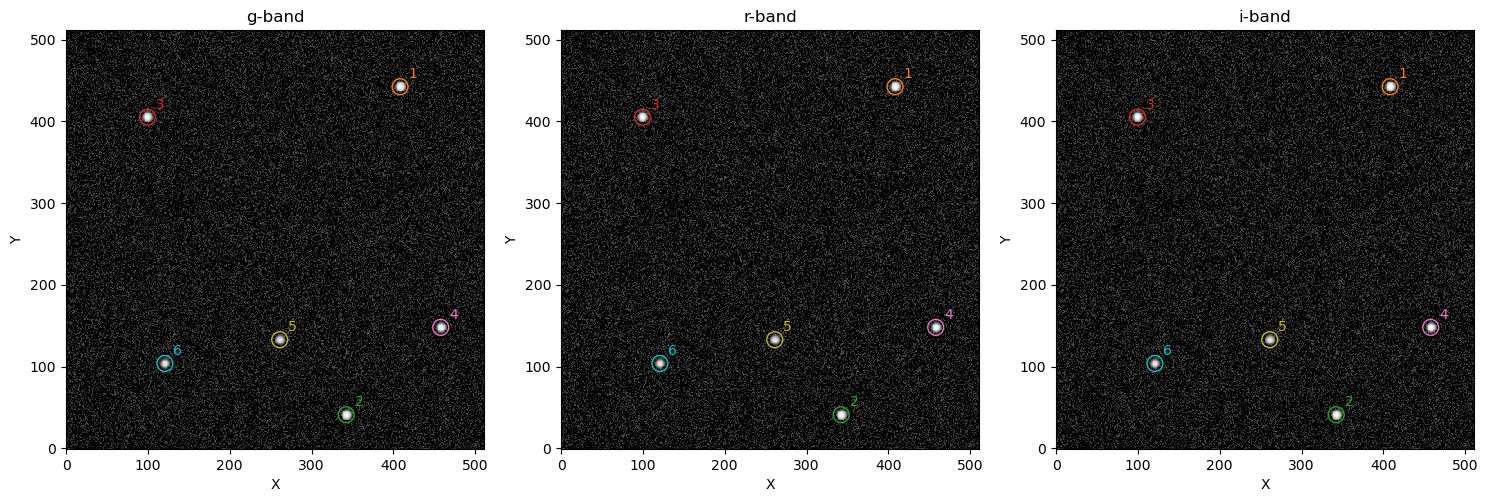

In [9]:
dphot = opticam.DifferentialPhotometer(
    out_directory='reduction_tutorial/reduced',  # same as the catalog's out_directory
    show_plots=True,  # show plots (useful for diagnosis and debugging)
    )

When initialising a `DifferentialPhotometer` object, the source catalogs are output for convenience (unless `show_plots=False`). We can now create our relative light curve:

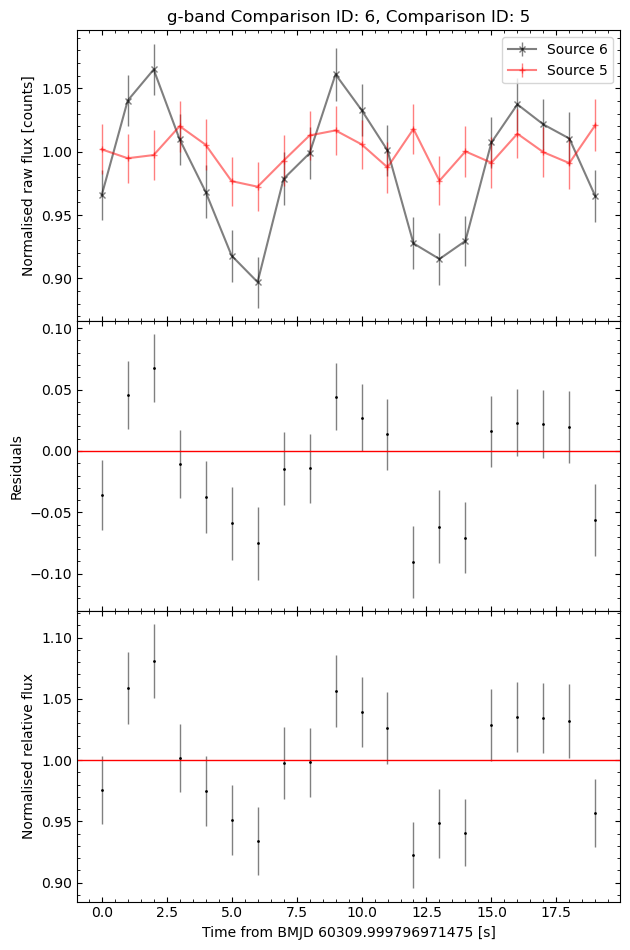

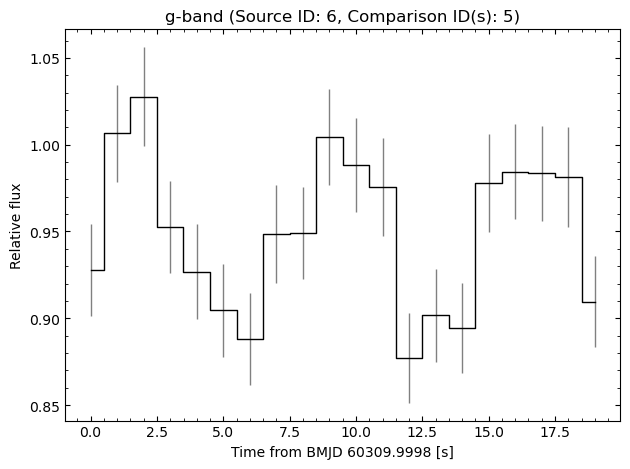

[OPTICAM] g-band target ID 6 was matched to r-band target ID 6
[OPTICAM] g-band comparison ID 5 was matched to r-band comparison ID 5


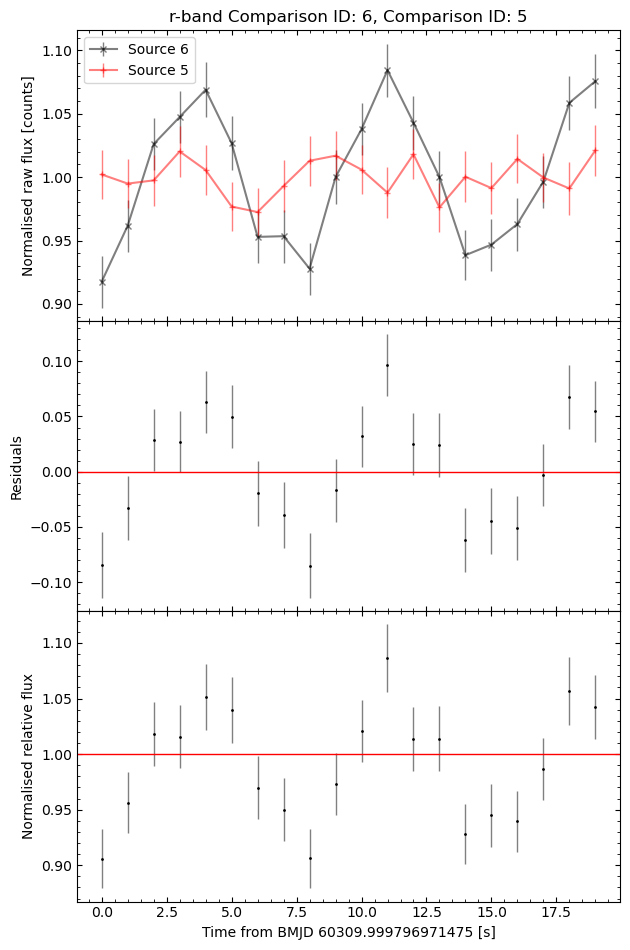

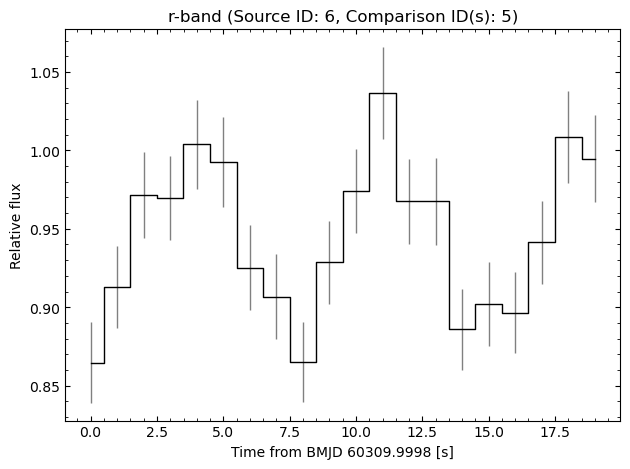

[OPTICAM] g-band target ID 6 was matched to i-band target ID 6
[OPTICAM] g-band comparison ID 5 was matched to i-band comparison ID 5


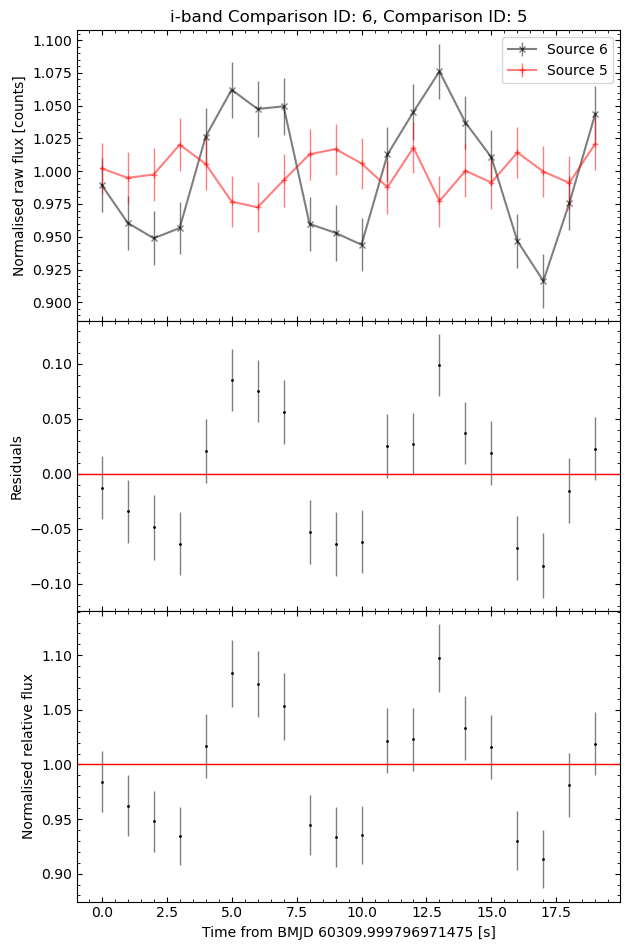

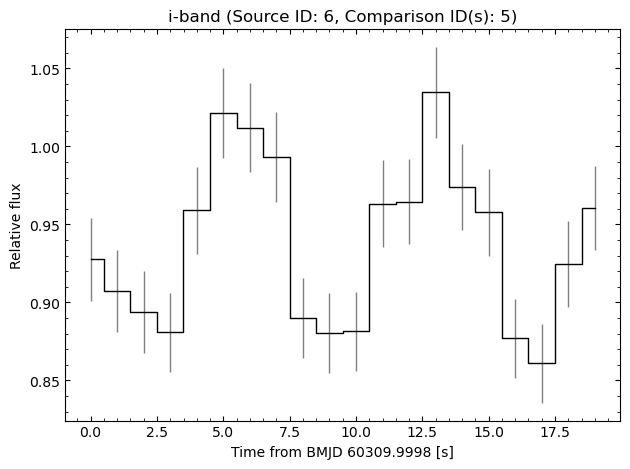

/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [10]:
target = 6  # source of interest
comparisons = [5]  # comparison sources

annulus_analyzer = dphot.get_relative_light_curve(
    'g-band',  # filter for which to compute the relative light curve
    target,  # source of interest
    comparisons,  # comparison sources
    phot_label='aperture_annulus',  # label for the photometry results
    prefix='test',  # prefix for the output files (e.g., the name of the target source)
    match_other_cameras=True,  # match sources across cameras
    show_diagnostics=True,  # show diagnostic plots (useful for diagnosis and debugging)
    )

When relative light curves are computed, the relative light curves are shown if `show_plots=True`, and an `Analyzer` object is returned (see the [timing methods tutorial](timing_methods.ipynb) for more details on this). The light curve is plotted in seconds from a reference Barycentric Modified Julian Date (BMJD), which is defined such that the first data point is at $t=0$ s.

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics=False`.

The `get_relative_light_curve()` method can also match sources across filters by setting `match_other_cameras=True`. However, this can misidentify sources, so care should be taken to check the correct sources are identified. In this case, we can see that the identified sources are correct, and so we don't have to manually create relative light curves for each filter. For the optimal light curves, however, I will show how to merge `Analyzer` instances using the `join()` method if you match the sources manually. First, let's define the individual `Analyzer` instances:

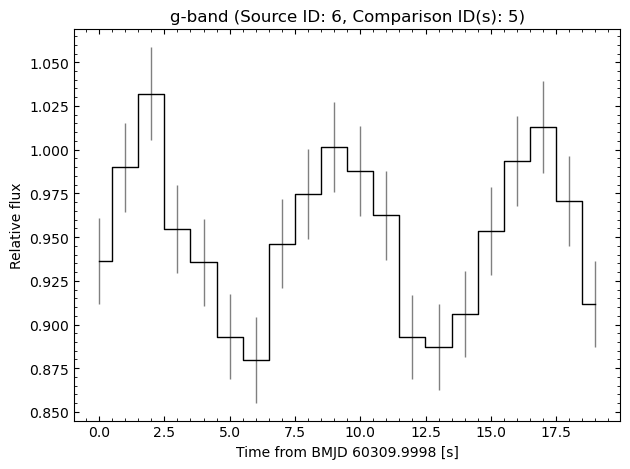

/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


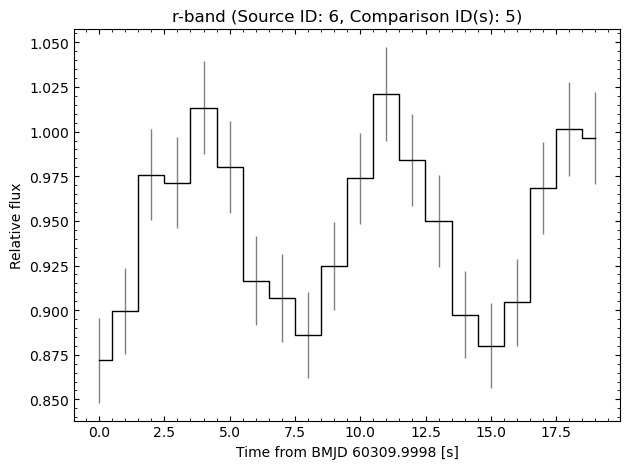

/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


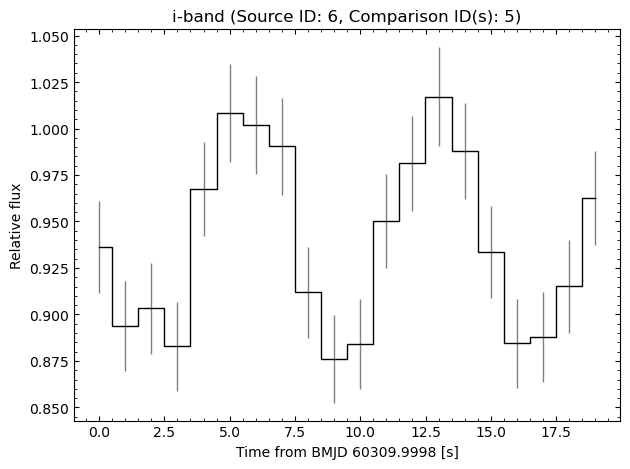

/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [11]:
g_band_optimal_analyzer = dphot.get_relative_light_curve(
    'g-band',
    target,
    comparisons,
    phot_label='optimal',
    prefix='test',
    match_other_cameras=False,
    show_diagnostics=False,
    )

r_band_optimal_analyzer = dphot.get_relative_light_curve(
    'r-band',
    target,
    comparisons,
    phot_label='optimal',
    prefix='test',
    match_other_cameras=False,
    show_diagnostics=False,
    )

i_band_optimal_analyzer = dphot.get_relative_light_curve(
    'i-band',
    target,
    comparisons,
    phot_label='optimal',
    prefix='test',
    match_other_cameras=False,
    show_diagnostics=False,
    )

Now let's combine them all into a single instance:

In [12]:
# join g-band with r-band
optimal_analyzer = g_band_optimal_analyzer.join(r_band_optimal_analyzer)

# join g-band and r-band with i-band
optimal_analyzer = optimal_analyzer.join(i_band_optimal_analyzer)

To check the `Analyzer` instances have merged properly, let's try plotting the light curves:

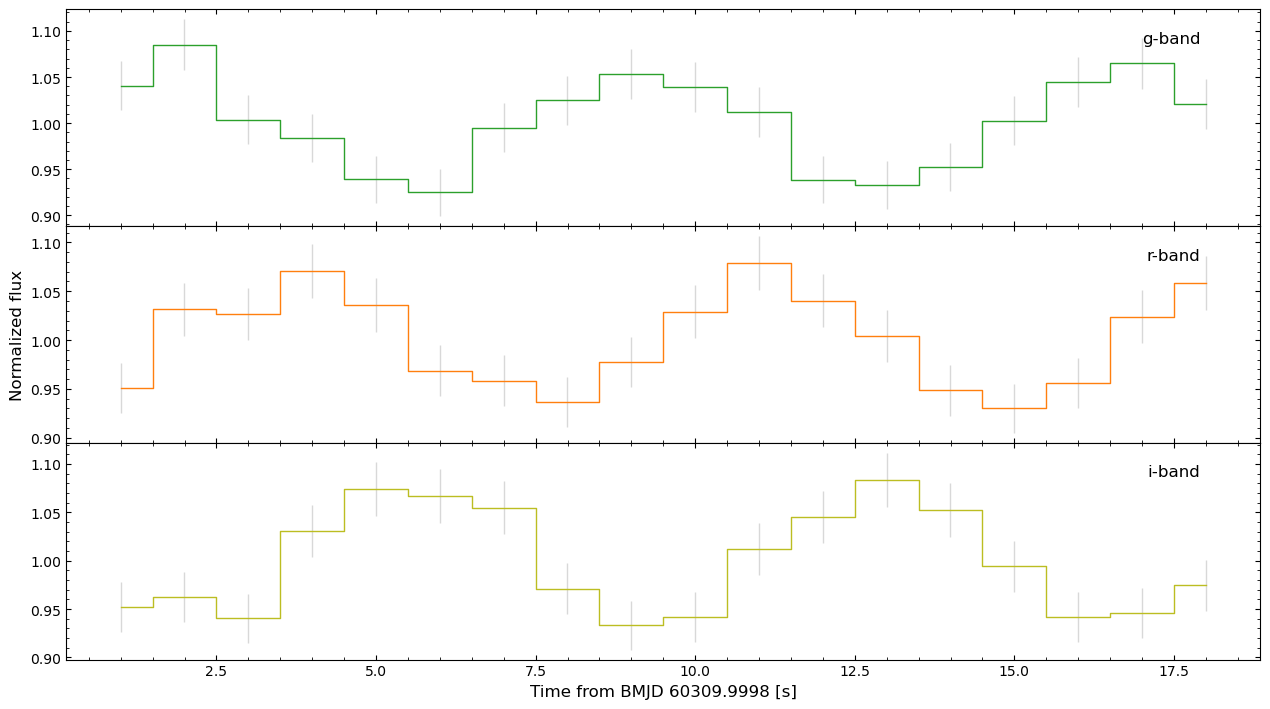

In [13]:
fig = optimal_analyzer.plot_light_curves()

As we can see, all three light curves have been combined successfully combined into a single `Analyzer` instance, allowing for timing analyses to be performing on all three light curves simultaneously.

That concludes the reduction tutorial for `opticam`! Next, I recommend checking out the [applying corrections](applying_corrections.ipynb) and [photometry](photometry.ipynb) tutorials. To explore the quick-look timing analysis routines available in `opticam`, see the [timing methods tutorial](timing_methods.ipynb).